# A grid based model SEPP model

In (1), an explicitly grid-based self-exciting point process (SEPP) model was considered.  The paper (1) is mostly concerned with two field-trials of the SEPP or epidemic-type aftershock sequence (ETAS) type prediction models.  There is no real discussion as to why a grid based model was chosen, compared to the earlier continuous space model using kernel density estimation.

### References:

1. Mohler et al. "Randomized Controlled Field Trials of Predictive Policing". Journal of the American Statistical Association (2015) DOI:10.1080/01621459.2015.1077710
2. Lewis, Mohler, "A Nonparametric EM algorithm for Multiscale Hawkes Processes", preprint (2011) see http://math.scu.edu/~gmohler/EM_paper.pdf

# The model

The area of interest is divided into a grid; 150m squares were used in (1).  To quote from (1):

> The size of the grid cells on which μ is defined can be estimated by
maximum likelihood and in general the optimum size of the grid
cell will decrease with increasing data. However, for a fixed area
flagged for patrol, a greater number of small hotspots are more
difficult to patrol than a small number of large hotspots. The
150 × 150 m hotspots were chosen in this study to be the size
of a city block in Foothill and were then held constant across all
of the experimental regions.

The model looks _at each grid cell individually_ and uses what we might recognise as a Hawkes process (in the original form studied by Hawkes, not the more general form).  In grid cell $n$, the conditional intensity $\lambda_n(t)$ is given by

\begin{equation} \lambda_n(t) = \mu_n + \sum_{t^i_n < t} \theta \omega e^{-\omega(t-t^i_n)}
\tag{eq 1}
\end{equation}

where here:

- $\mu_n$ is the background rate in cell $n$.
- $\omega$ and $\theta$ control the "near-repeat" behaviour.  Notice that these do not depend upon $n$.
- As always, we sum over events $t^i_n$ which have occurred before the time of interest $t$, and _which have occurred in the same grid cell_.

It seems surprising that inter-cell interactions are not considered at all in this model.

# Model fitting

I do not quite understand the paper (1) here.  The following is what I think _should_ have been written.

We make initial estimates for $\mu_n$ (perhaps setting each $\mu_n$ to be the same) and $\omega, \theta$.  Then we alternate the following two steps until convergence:

### Expectation step:

Compute the upper triangular "probability matrix":

$$ p^{n}_{ji} \propto \theta\omega e^{-\omega(t_n^i - t_n^j)}, \qquad p^n_{ii} \propto \mu_n $$

where $p^{n}_{ji}$ is the probability, in cell $n$, then event $j$ triggered event $i$.  We set $p^n_{ji} = 0$ if $j > i$ and then normalise so that each column of the matrix sums to $1$ (which is why in the above formula I only give what $p^n_{ji}$ is proportional to).

### Maximisation step:

We then compute the new parameters:

$$ \omega = \frac{\sum_n \sum_{i<j} p^n_{ij}}{\sum_n \sum_{i<j} p^n_{ij}(t_n^j - t_n^i)}, \qquad
\theta = \frac{\sum_n \sum_{i<j} p^n_{ij}}{\sum_n \sum_j 1}, \qquad \mu_n = \frac{\sum_i p^n_{ii}}{T} $$
where $T$ is the time window of data under consideration.

(Note here I have given an estimate for $\mu_n$, whereas (1) seems to sum over $n$ and give an estimate for $\mu$, the total rate across the study area, but does not specify a suitable estimate for $\mu_n$.)

# Simulation

Simulating a process satisfying (eq 1) can be accomplished in the same way as simulating a more general Hawkes-type process.  However, in the simple form we have here, we can find faster simulation methods.

1. We simulate the "branching process" form.  This can be done on a cell by cell basis.
2. So firstly we simulate a homogeneous Poisson process with intensity $\mu_n$.
3. Then each point $i$ gives rise to an independent inhomogeneous Poisson process with intensity $\theta\omega e^{-\omega(t-t_i)}$ where event $i$ occurred at time $t_i$.

To simulate the process in 3 we make use of the following result.  If $\lambda^*$ is the conditional intensity of a process, then the _compensator_ is
$$ \Lambda(t) = \int_0^t \lambda^*(s) \ ds. $$
Then we have the following useful result:

> If $(t_1,\cdots,t_k)$ is a realisation of time $[0,T]$ of a point process with conditional intensity $\lambda^*$ then $\{\Lambda(t_1),\cdots,\Lambda(t_k)\}$ is unit rate Poisson process.

The converse to this statement is also true.  So, if $\Lambda$ is invertible, then we may simulate a unit rate Poisson process $\{s_1,\cdots,s_k\}$ and then $t_i  = \Lambda^{-1}(s_i)$ will be a process with conditional intensity $\lambda^*$.

In our case, $\lambda^*(t) = \theta\omega e^{-\omega t}$ (translating so that the "trigger" event occurs at $t=0$) and so
$$ \Lambda(t) = \theta \int_0^t \omega e^{-\omega s} \ ds = \theta \Big[ -e^{-\omega s} \Big]_0^t
= \theta\big( 1- e^{-\omega t} \big). $$
This has inverse $\Lambda^{-1}(s) = \omega^{-1} \log(\theta / (\theta - s) )$ defined for $0\leq s < \theta$. So

- Simulate a unit rate Poisson process $\{s_1,\cdots,s_k\}$ on $[0,\theta)$ and then set $t_i = \Lambda^{-1}(s_i)$ to get the "after-shock" events.
- This allows us to think about the parameters $\theta$ and $\omega$.  $\theta$ controls the rate of the process-- we expect an average of $\theta$ events.  $\omega$ controls the scale of the resulting process.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Simulation of the process in a single cell

In [2]:
import open_cp.sources.sepp as source_sepp

[(-0.1, 0.1), (900, 1000)]

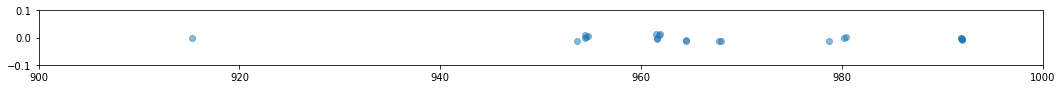

In [3]:
process = source_sepp.SelfExcitingPointProcess(
    background_sampler = source_sepp.HomogeneousPoissonSampler(rate=0.1),
    trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=10))

events = process.sample(0, 1000)

fig, ax = plt.subplots(figsize=(18,1))
ax.scatter(events, (np.random.random(len(events))-0.5) * 0.03, alpha=.5)
ax.set(xlim=[900, 1000], ylim=[-0.1,0.1])

## Model fitting for cells with varying background rate

We'll create 100 cells with varying background rate, but the same $\omega, \theta$

In [4]:
def simulate(exp_rate=10):
    cells = np.empty(100, dtype=np.object)
    for i in range(100):
        rate = 0.01 + 0.49 * i / 100
        process = source_sepp.SelfExcitingPointProcess(
            background_sampler = source_sepp.HomogeneousPoissonSampler(rate=rate),
            trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=exp_rate))
        events = process.sample(0, 1000)
        cells[i] = events[events >= 500]
        cells[i] -= cells[i][0]
    return cells

The number of events in each cell varies quite a lot.

In [5]:
cells = simulate()
min(len(t) for t in cells), max(len(t) for t in cells)

(7, 536)

In [6]:
import open_cp.seppexp

In [7]:
def optimise(cells, initial_omega=10, iterations=100):
    omega = initial_omega
    theta = .5
    mu = [.5] * len(cells)

    for _ in range(iterations):
        omega, theta, mu = open_cp.seppexp.maximisation(cells, omega, theta, mu, 500)
    return omega, theta, mu

def optimise_corrected(cells, initial_omega=10, iterations=100):
    omega = initial_omega
    theta = .5
    mu = [.5] * len(cells)

    for _ in range(iterations):
        omega, theta, mu = open_cp.seppexp.maximisation_corrected(cells, omega, theta, mu, 500)
    return omega, theta, mu

In [8]:
omega, theta, mu = optimise(cells)
omega, theta

(9.9180045688999705, 0.5006719121547003)

In [9]:
omegac, thetac, muc = optimise_corrected(cells, 0.1, 1000)
omegac, thetac

(9.9173162805334218, 0.50068519443721549)

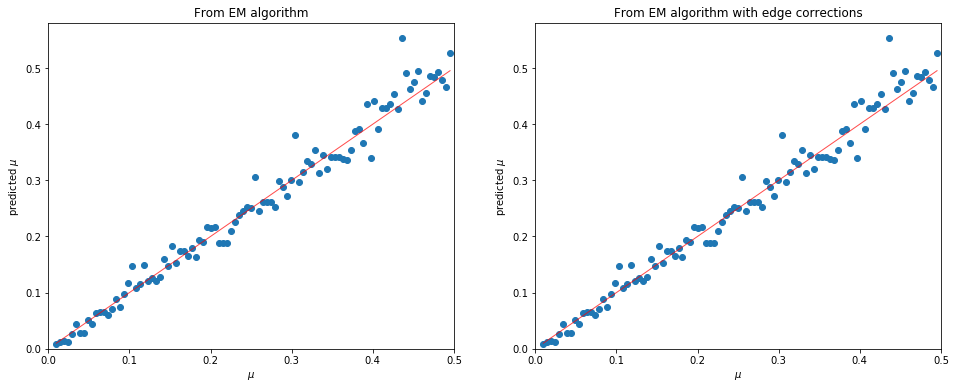

In [11]:
actual_mu = [ 0.01 + 0.49 * i / 100 for i in range(100) ]

fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].plot(actual_mu, actual_mu, color="red", linewidth=1, alpha=0.7)
ax[0].scatter(actual_mu, mu)
ax[0].set(xlim=[0,0.5], ylim=[0,np.max(mu)*1.05], xlabel="$\\mu$", ylabel="predicted $\\mu$",
         title="From EM algorithm")
ax[1].plot(actual_mu, actual_mu, color="red", linewidth=1, alpha=0.7)
ax[1].scatter(actual_mu, muc)
ax[1].set(xlim=[0,0.5], ylim=[0,np.max(mu)*1.05], xlabel="$\\mu$", ylabel="predicted $\\mu$",
         title="From EM algorithm with edge corrections")
None

Noting that our initial estimate for every $\mu$ is $0.5$, this is good convergence.

However, if we try a rather smaller value of $\omega$, then the optimisation doesn't find the real parameters, tending to systematically over-estimate the background rate $\mu$ and under-estimate the aftershock rate.

In [12]:
cells = simulate(0.1)
omega, theta, mu = optimise(cells, 0.1, 1000)
omega, theta

(0.22281847025527352, 0.27779001776550361)

In [13]:
omegac, thetac, muc = optimise_corrected(cells, 0.1, 1000)
omegac, thetac

(0.14070241893232935, 0.36178527364385754)

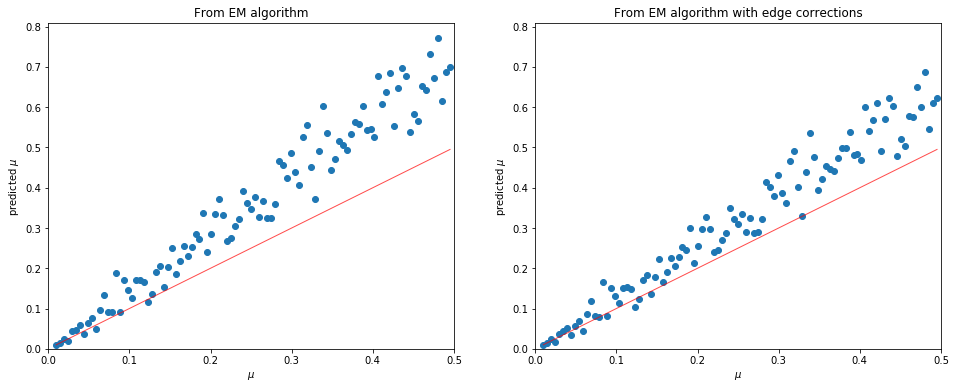

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].plot(actual_mu, actual_mu, color="red", linewidth=1, alpha=0.7)
ax[0].scatter(actual_mu, mu)
ax[0].set(xlim=[0,0.5], ylim=[0,np.max(mu)*1.05], xlabel="$\\mu$", ylabel="predicted $\\mu$",
         title="From EM algorithm")
ax[1].plot(actual_mu, actual_mu, color="red", linewidth=1, alpha=0.7)
ax[1].scatter(actual_mu, muc)
ax[1].set(xlim=[0,0.5], ylim=[0,np.max(mu)*1.05], xlabel="$\\mu$", ylabel="predicted $\\mu$",
         title="From EM algorithm with edge corrections")
None